<a href="https://colab.research.google.com/github/BojanMakivic/Predicting-fitness-level-of-cancer-survivors/blob/master/TF%2C_sklearn_cont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF, sklearn continuous model

# Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd

# Figures plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# GUI to import data file (xlsx)

In [3]:
from google.colab import files
import io
#uploaded = files.upload() 
#df = pd.read_excel(io.BytesIO(uploaded['Data.xlsx']))

df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
df = pd.DataFrame(df)

In [ ]:
df.info() # BW nad BH are standing for body weight and body height, respectively

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     1712 non-null   int64  
 1   Gender  1712 non-null   object 
 2   BW      1712 non-null   float64
 3   BH      1712 non-null   int64  
 4   Wmax    1712 non-null   int64  
 5   Norm    1712 non-null   float64
 6   Level   1712 non-null   object 
 7   Type    1712 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 107.1+ KB


Good      973
Middle    622
Bad       117
Name: Level, dtype: int64

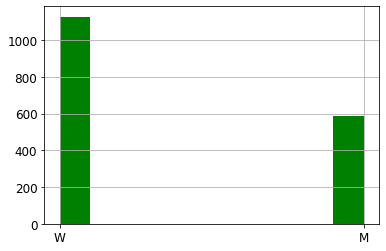

In [4]:
# Histogram of gender distribution
df['Gender'].hist(label=int,align='mid',color=['green'])
df['Level'].value_counts()

## Writing a function for BMI calculation and adding a new column
https://en.wikipedia.org/wiki/Body_mass_index

In [5]:
# Function
def bmi(bw,bh):
    return bw/((bh/100)*(bh/100))

In [6]:
# Adding a new column
df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 

In [7]:
#df.loc[df['Gender'] == 'W'].describe()
df.describe()

,Age,BW,BH,Wmax,Norm,BMI
count,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000
mean,55.765771,75.929030,168.342874,118.494743,85.097715,26.726015
std,10.930445,16.636734,8.964106,41.874907,23.719701,5.137146
min,18.000000,38.000000,136.000000,26.000000,19.620253,15.570934
25%,49.000000,63.000000,162.000000,88.000000,68.965517,23.183603
50%,56.000000,73.500000,168.000000,112.000000,84.274745,25.884072
75%,62.000000,86.000000,174.000000,141.000000,100.934829,29.666548
max,88.000000,143.000000,200.000000,327.000000,175.652174,49.480969


## Histogram distribution of each attribute

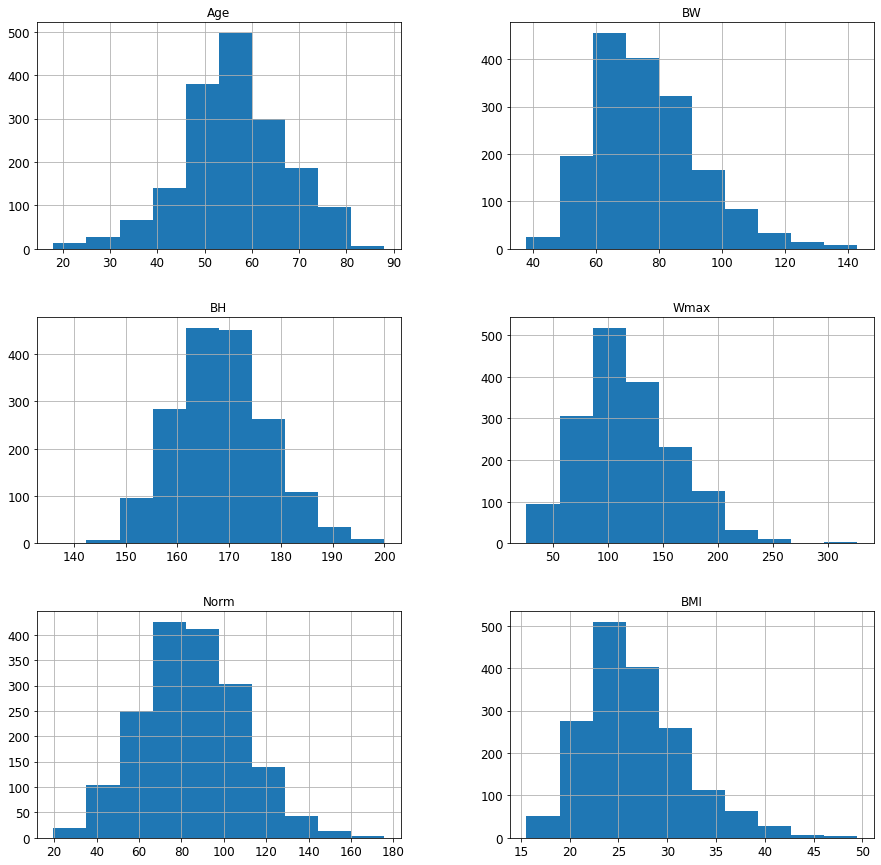

In [8]:
df.hist(bins=10, figsize=(15,15))
plt.show()

In [9]:
np.random.seed(42) # To ensure the repeatability of train/test results. It means that every time we run models the train/test samples will be same
del df['Norm']
del df['Type']
del df['Level']
#del df['Gender']
#del df['BW']
#del df['BMI']
#del df['Wmax'] # continuous

In [10]:
df

,Age,Gender,BW,BH,Wmax,BMI
0,40,W,57.0,165,130,20.936639
1,51,W,63.0,159,131,24.919900
2,66,M,66.0,165,118,24.242424
3,66,W,86.0,155,75,35.796046
4,72,M,72.0,170,105,24.913495
...,...,...,...,...,...,...
1707,55,M,63.0,163,87,23.711845
1708,57,W,71.0,164,57,26.397977
1709,65,W,63.0,168,112,22.321429
1710,67,W,68.0,163,84,25.593737


In [ ]:
#df=df.loc[df['Type'] == 'Brustkrebs']
#df=df.loc[df['Gender'] == 'W']
#df

# PREPARING TRAINING AND TEST SET

In [11]:
## CONTINUOUS

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_labels = train_set["Wmax"].copy()       # Save a copy of label variable
train_set = train_set.drop("Wmax", axis=1)    # Drop label variable from training set

In [12]:
train_num = train_set.to_numpy()
train_num

array([[54, 'W', 51.0, 168, 18.069727891156464],
       [63, 'M', 84.0, 171, 28.726787729557817],
       [61, 'M', 84.0, 170, 29.065743944636683],
       ...,
       [71, 'W', 77.0, 160, 30.078124999999993],
       [59, 'W', 72.0, 175, 23.510204081632654],
       [55, 'W', 73.0, 168, 25.86451247165533]], dtype=object)

In [13]:
train_num = train_set.drop(["Gender"], axis=1)  # Keep only numerical variables
train_num

,Age,BW,BH,BMI
408,54,51.0,168,18.069728
1357,63,84.0,171,28.726788
518,61,84.0,170,29.065744
1111,62,63.0,164,23.423557
538,76,65.0,148,29.674945
...,...,...,...,...
1130,49,87.0,178,27.458654
1294,53,67.0,159,26.502116
860,71,77.0,160,30.078125
1459,59,72.0,175,23.510204


# PIPELINE

In [14]:
# Pipline to scale numerical variables and transform categorical variable (gender) into binary

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
        ('std_scaler', MinMaxScaler()),])
train_transf = pipeline.fit_transform(train_num)

In [15]:
train_transf # Only numerical variables were scaled (Age, BW, BH and BMI)

array([[0.51428571, 0.12380952, 0.5       , 0.07368891],
       [0.64285714, 0.43809524, 0.546875  , 0.38796343],
       [0.61428571, 0.43809524, 0.53125   , 0.39795918],
       ...,
       [0.75714286, 0.37142857, 0.375     , 0.42781409],
       [0.58571429, 0.32380952, 0.609375  , 0.23412745],
       [0.52857143, 0.33333333, 0.5       , 0.30355552]])

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(train_num) #train_num
cat_attribs = ["Gender"]

full_pipeline = ColumnTransformer([
        ("num", pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),])

train_prepared = full_pipeline.fit_transform(train_set) # Training set is ready for use

In [17]:
train_prepared # Numerical and categorical variables are scaled

array([[0.51428571, 0.12380952, 0.5       , 0.07368891, 0.        ,
        1.        ],
       [0.64285714, 0.43809524, 0.546875  , 0.38796343, 1.        ,
        0.        ],
       [0.61428571, 0.43809524, 0.53125   , 0.39795918, 1.        ,
        0.        ],
       ...,
       [0.75714286, 0.37142857, 0.375     , 0.42781409, 0.        ,
        1.        ],
       [0.58571429, 0.32380952, 0.609375  , 0.23412745, 0.        ,
        1.        ],
       [0.52857143, 0.33333333, 0.5       , 0.30355552, 0.        ,
        1.        ]])

# SELECTING AND TRAINING THE MODEL

## Linear regression

In [116]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(n_jobs=1)
lin_reg_fit = lin_reg.fit(train_prepared, train_labels)

In [117]:
# RMSE for linear model
from sklearn.metrics import mean_squared_error

watt_predictions = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(train_labels, watt_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE is: ",lin_rmse) # We can see that the prediction error for linear model is 32.5 Watt 

RMSE is:  32.46354580734144


In [118]:
errors = abs(watt_predictions - train_labels)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 25.07 Watt.


In [119]:
lin_reg.score(train_prepared, train_labels)

0.40059638323238245

In [120]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(train_labels) * sum(errors / train_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.17 %.


### Fine-tune linear regression

In [121]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    
    {'copy_X': [True],
     'fit_intercept': [True],
     'n_jobs': [1,], 
     'normalize': [False]
  }]

model = LinearRegression()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_lr = GridSearchCV(model, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_lr.fit(train_prepared, train_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'copy_X': [True], 'fit_intercept': [True],
                          'n_jobs': [1], 'normalize': [False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [122]:
grid_search_lr.best_params_

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

In [123]:
grid_search_lr.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [124]:
negative_mse = grid_search_lr.best_score_
rmse = np.sqrt(-negative_mse)
rmse

32.63184662630656

## Support vector regressor (SVR)

In [125]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf", epsilon=3, C=100, cache_size= 100, degree=0.1, gamma='scale', max_iter = -1, tol =1, coef0= 0.1)
svm_reg_fit = svm_reg.fit(train_prepared, train_labels)

In [126]:
# RMSE for SVR model
from sklearn.metrics import mean_squared_error

watt_SVR_predictions = svm_reg.predict(train_prepared)
SVR_mse = mean_squared_error(train_labels, watt_SVR_predictions)
SVR_rmse = np.sqrt(SVR_mse)
print ("RMSE is: ",SVR_rmse) # We can see that the prediction error for SVR model is 32.6 Wat

RMSE is:  31.332635974796254


In [127]:
errors = abs(watt_SVR_predictions - train_labels)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 23.83 Watt.


In [128]:
svm_reg.score(train_prepared, train_labels)

0.44163097515317706

In [129]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(train_labels) * sum(errors / train_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 76.68 %.


### Fine-tune SVR

In [130]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    
    {'C': [100],
     'cache_size': [100],
     'coef0': [0.1],
     'degree': [0.1],
     'epsilon': [3],
     'gamma': ['scale'],
     'kernel': ['rbf'],
     'max_iter': [-1],
     'shrinking': [True],
     'tol': [1]
  }]

svm_reg = SVR()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_svr = GridSearchCV(svm_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_svr.fit(train_prepared, train_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [100], 'cache_size': [100], 'coef0': [0.1],
                          'degree': [0.1], 'epsilon': [3], 'gamma': ['scale'],
                          'kernel': ['rbf'], 'max_iter': [-1],
                          'shrinking': [True], 'tol': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [131]:
grid_search_svr.best_params_

{'C': 100,
 'cache_size': 100,
 'coef0': 0.1,
 'degree': 0.1,
 'epsilon': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 1}

In [132]:
negative_mse = grid_search_svr.best_score_
rmse = np.sqrt(-negative_mse)
rmse

31.84480719338325

## Random forest model

In [133]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42, oob_score=True, n_estimators=2000, max_features=2, bootstrap = True, max_depth = 8, min_samples_leaf = 4, min_samples_split = 2)
forest_fit = forest_reg.fit(train_prepared, train_labels)

In [134]:
# RMSE for random forest model

watt_RF_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(train_labels, watt_RF_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE is: ", forest_rmse) # We can see that the prediction error for linear model is 13.1 Wat (until now the model with lowest prediction error)

RMSE is:  27.29217825851524


In [135]:
errors = abs(watt_RF_predictions - train_labels)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 21.16 Watt.


In [136]:
forest_reg.score(train_prepared, train_labels)

0.5763532779942611

In [137]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(train_labels) * sum(errors / train_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 79.04 %.


In [138]:
np.mean(mape)

20.957850454762383

### Fine-tune RF

In [139]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    {'bootstrap': [True],
     'n_estimators': [2000], 
     'max_features': [2],
     'max_depth': [8],
     'min_samples_leaf': [4],
     'min_samples_split': [2]
  }]

forest_reg = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_rf.fit(train_prepared, train_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [140]:
grid_search_rf.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [141]:
grid_search_rf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [142]:
negative_mse = grid_search_rf.best_score_
rmse = np.sqrt(-negative_mse)
rmse

32.17210985495504

# VALIDATION OF MODELS (Training set)

'''The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:'''

In [143]:
# Function to display the score statistics

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [144]:
from sklearn.model_selection import cross_val_score

## Linear model

In [145]:
lin_scores = cross_val_score(lin_reg, train_prepared, train_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [30.50006731 27.46985412 38.43562164 32.48211187 38.07501257 31.43026112
 31.98348684 31.11989247 32.31836557 30.94683766]
Mean: 32.476151117652705
Standard deviation: 3.1838691597143693


## SVR

In [146]:
SVR_scores = cross_val_score(svm_reg, train_prepared, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

Scores: [33.53741595 29.08001309 42.97127343 35.11344792 40.50355359 32.11832146
 34.12441947 33.42640241 32.46191246 31.71055972]
Mean: 34.50473194994824
Standard deviation: 3.9671764889564


## Random forest

In [147]:
forest_scores = cross_val_score(grid_search_rf, train_prepared, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [30.52477115 27.55576798 38.69304532 31.84504516 35.90950468 30.83684027
 32.09978164 31.59061076 31.00326179 30.30078729]
Mean: 32.03594160309178
Standard deviation: 2.9568730311917206


In [148]:
# Return the table of cross-validation for all three models

scores = cross_val_score(grid_search_lr,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
scores_rf = cross_val_score(grid_search_rf,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
scores_svr = cross_val_score(grid_search_svr,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
a = pd.Series(np.sqrt(-scores)).describe()
b = pd.Series(np.sqrt(-scores_svr)).describe()
c = pd.Series(np.sqrt(-scores_rf)).describe()

scores_df = pd.DataFrame({
    "lin_reg": a,
    "SVR":b,
    "forest_reg": c
    })
scores_df

,lin_reg,SVR,forest_reg
count,10.000000,10.000000,10.000000
mean,32.476151,31.710580,32.035942
std,3.356093,3.078759,3.116818
min,27.469854,27.693028,27.555768
25%,30.990101,30.202528,30.602788
50%,31.706874,31.082412,31.296936
75%,32.441175,32.317975,32.036098
max,38.435622,37.810281,38.693045


# FEATURE IMPORTANCE

In [150]:
feature_importances = grid_search_rf.best_estimator_.feature_importances_
feature_importances

array([0.27127596, 0.14448407, 0.28657013, 0.10717287, 0.09903613,
       0.09146085])

In [151]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.28657012540591353, 'BH'),
 (0.27127595877919763, 'Age'),
 (0.14448406875567027, 'BW'),
 (0.10717287075652097, 'BMI'),
 (0.09903612904117477, 'M'),
 (0.09146084726152283, 'W')]

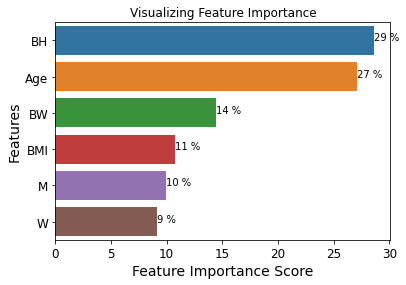

In [152]:
import seaborn as sns

feature_imp = pd.Series(feature_importances,index=attributes).sort_values(ascending=False)
sns.barplot(x=feature_imp*100, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Feature Importance")
for index, value in enumerate(feature_imp*100):
    plt.text(value, index, str("{:.0f}".format(value)+" %")) # Rounding the float
plt.show()

# TESTING THE MODEL

In [159]:
final_model = grid_search_rf

X_test = test_set.drop("Wmax", axis=1)
y_test = test_set["Wmax"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [160]:
final_rmse

32.582270475755514

In [ ]:
#score_final = cross_val_score(forest_reg,  X_test_prepared, y_test, scoring="neg_mean_squared_error", cv=10)
#final = pd.Series(np.sqrt(-score_final)).describe()
#final

In [161]:
from sklearn import metrics
from sklearn.metrics import r2_score

y_oob = final_model.predict(X_test_prepared)
print("R2",r2_score(y_test, y_oob)) # Amount of the variation in the response variable which is predictable from the input independent variable
print("R2",final_model)

R2 0.38620767024411207
R2 GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
          

In [162]:
from scipy import stats
# 95% confidence interval for the test RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([29.68343989, 35.24346883])

In [163]:
errors = abs(final_predictions - y_test)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 24.99 Watt.


In [165]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(y_test) * sum(errors / y_test)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.52 %.


# PREDICTING Wmax

In [ ]:
import warnings
warnings.filterwarnings("ignore")

age = input("Please enter the AGE: ")
age = int(age)
print("Age is: ", age)

bmi = input ("Please ebter the BMI: ")
bmi = int(bmi)
print("BMI is: ", bmi)

bh = input("Please enter the BODY HEIGHT: ")
bh = int(bh)
print("Body height is: ", bh)

bw = input("Please enter the BODY WEIGHT: ")
bw = int(bw)
print("Body weight is: ", bw)

g = input("Please enter your gender(W for women or M for man): ").upper()
print("Gender is: ", g)

a = pd.DataFrame({'Age':[age],'BMI':[bmi],'Gender':[g],'BH':[bh],'BW':[bw]})
b = full_pipeline.transform(a)
print("Your predicted Wmax is: ",int(final_model.predict(b)))

Please enter the AGE: 40
Age is:  40
Please ebter the BMI: 27
BMI is:  27
Please enter the BODY HEIGHT: 180
Body height is:  180
Please enter the BODY WEIGHT: 87
Body weight is:  87
Please enter your gender(W for women or M for man): M
Gender is:  M
Your predicted Wmax is:  183
